In [1]:
import numpy as np
import pandas as pd
import networkx as nx
from random import choice, randint, uniform
from itertools import chain
from statsmodels.formula.api import logit
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import pickle

In [2]:
# 识别后门调整集
def find_backdoor_adjustment_set(G, X, Y):
    # 找到所有共同祖先节点
    ancestors_of_X = nx.ancestors(G, X)
    ancestors_of_Y = nx.ancestors(G, Y)
    common_ancestors = ancestors_of_X.intersection(ancestors_of_Y)
        
    # 存储所有后门路径的节点集合
    backdoor_paths_nodes = []

    # 遍历每个共同祖先节点
    for ancestor in common_ancestors:
        # 找到从公共祖先到X的路径
        paths_to_X = list(nx.all_simple_paths(G, source=ancestor, target=X))
        # 找到从公共祖先到Y的路径
        paths_to_Y = list(nx.all_simple_paths(G, source=ancestor, target=Y))
        # 如果找到的从公共祖先到Y的路径中包含了X，则去掉该路径
        paths_to_Y = [path for path in paths_to_Y if X not in path]

        # 将从公共祖先到X的路径和从公共祖先到Y的路径组合成完整的后门路径
        for path_X in paths_to_X:
            for path_Y in paths_to_Y:
            # 从路径中去掉公共祖先和终点X、Y，防止重复
                full_path = set(path_X[:-1] + path_Y[1:-1])
                # 添加路径到后门路径集合
                if full_path:
                    backdoor_paths_nodes.append(full_path)
        
    # 找到覆盖所有路径的最小集合
    return minimum_cover(backdoor_paths_nodes)

# 求最小覆盖集
def minimum_cover(sets):
    # 展开集合中的所有元素
    elements = set(chain(*sets))
    cover = set()
    
    while sets:
        # 找到最常出现的元素
        most_common = max(elements, key=lambda e: sum(1 for s in sets if e in s))
        cover.add(most_common)
            
        # 移除包含该元素的所有集合
        sets = [s for s in sets if most_common not in s]
        elements.discard(most_common)
        
    return list(cover)

In [3]:
# 计算从干预变量到结果变量的总体因果效应（ACE）
def calculate_ace(G, adj_matrix, X, Y):
    paths = list(nx.all_simple_paths(G, source=X, target=Y))
    ace = 0
    for path in paths:
        # 串联：每条路径上的系数相乘
        path_weight = np.prod([adj_matrix[path[i], path[i+1]] for i in range(len(path) - 1)])
        # 并联：每条路径的效应相加
        ace += path_weight
    return ace

In [38]:
# 参数定义
num_dags = 100  # DAG数量
num_nodes_range = (5, 15)  # 每个DAG节点数量范围
# sample_sizes = [100, 200, 500]  # 数据集规模
sample_sizes = [2000, 4000, 6000, 8000, 10000, 100000]
# noise_levels = [i for i in [0.1, 0.5, 1.0, 5.0, 10.0]]  # 噪声强度
noise_levels = [0.5]
data_file_name = 'dag_data_2.pkl'

# 存储结果
dag_data = []

In [5]:
# 生成DAG，增强代码复用性
# 生成随机节点数量的DAG
def generate_random_dag(i):
    num_nodes = randint(*num_nodes_range)
    G = nx.DiGraph()
    G.add_nodes_from(range(num_nodes))
    
    # 创建邻接矩阵，并随机生成有向边
    adj_matrix = np.zeros((num_nodes, num_nodes))
    for u in range(num_nodes):
        for v in range(u + 1, num_nodes):
            if np.random.rand() > 0.7:  # 30%几率添加边
                # 我觉得这个边权应该有正有负，这样更全面
                weight = uniform(-1.0, 1.0)
                # weight = uniform(0.1, 1.0)
                adj_matrix[u, v] = weight
                G.add_edge(u, v, weight=weight)

    # # 打印邻接矩阵
    # print(f"\nDAG {i} Adjacency Matrix with Weights:\n", adj_matrix)

    # 选择干预和结果变量
    intervention_var = choice(list(G.nodes))
    outcome_var = choice([n for n in G.nodes if n != intervention_var])

    # 识别后门调整集
    backdoor_set = find_backdoor_adjustment_set(G, intervention_var, outcome_var)
    # print(f"Backdoor Adjustment Set for DAG {i} from {intervention_var} to {outcome_var}:", backdoor_set)

    # 计算从干预变量到结果变量的总体因果效应（ACE）
    ace = calculate_ace(G, adj_matrix, intervention_var, outcome_var)
    # print(f"ACE for DAG {i} from {intervention_var} to {outcome_var}:", ace)

    return num_nodes, G, adj_matrix, intervention_var, outcome_var, backdoor_set, ace


In [39]:
# 生成随机DAG，满足马尔可夫条件和忠实性
def generate_random_dags(start_id, num_dags, dag_data): # start_id为DAG编号，num_dags为此次生成的DAG数量
    for i in range(num_dags):
        num_nodes, G, adj_matrix, intervention_var, outcome_var, backdoor_set, ace = generate_random_dag(i)
        # 当ace为0时，重新生成DAG
        while ace == 0:
            num_nodes, G, adj_matrix, intervention_var, outcome_var, backdoor_set, ace = generate_random_dag(i)

        # 生成不同规模的数据及噪声
        for sample_size in sample_sizes:
            for noise_level in noise_levels:
                data = np.zeros((sample_size, num_nodes))
                for t in range(sample_size):
                    # 为拓扑排序中没有父节点的节点添加初始值，初始值为[-10, 10]之间的随机数
                    # print("拓扑排序：", list(nx.topological_sort(G)))
                    for node in nx.topological_sort(G):
                        # print(node, G.predecessors(node))
                        if not list(G.predecessors(node)):
                            data[t, node] = np.random.uniform(-10, 10) 
                    # print("data:", data)
                    # 初始化根节点的值
                    for node in nx.topological_sort(G): # 拓扑排序
                        if list(G.predecessors(node)):
                            noise = np.random.normal(0, noise_level) # 添加高斯噪声
                            parent_values = sum(adj_matrix[parent, node] * data[t, parent] for parent in G.predecessors(node))
                            data[t, node] = parent_values + noise
                            # data[t, node] = parent_values
                    # for node in nx.topological_sort(G): # 拓扑排序
                        # noise = np.random.normal(0, noise_level) # 添加高斯噪声
                        # data[t, node] = data[t, node] + noise
                # print("data:", data)
                # 存储DAG数据及因果效应
                dag_data.append({
                    'dag_id': start_id+i+1,
                    'sample_size': sample_size,
                    'noise_level': noise_level,
                    'weight_matrix': adj_matrix,
                    'intervention_var': intervention_var,
                    'outcome_var': outcome_var,
                    'backdoor_set': backdoor_set,
                    'ace': ace,
                    'data': pd.DataFrame(data, columns=[f'X{j}' for j in range(num_nodes)]),
                    'estimated_ace': None,
                    'lower_bound_of_confidence_interval': None,
                    'upper_bound_of_confidence_interval': None
                })
        # 展示一下当前的进度
        print(f"Generated DAG {start_id+i+1} out of {start_id+num_dags}")
    return dag_data
                # print(f"Data for DAG {i} with {sample_size} samples and noise level {noise_level}:\n", dag_data[-1]['data'])

In [40]:
# 保存 dag_data 到本地文件，此处应在还没有dag_data.pkl时使用
with open(data_file_name, 'wb') as f:
    pickle.dump(dag_data, f)

# 读取本地文件中的 dag_data
with open(data_file_name, 'rb') as f:
    dag_data = pickle.load(f)
    # 查看一下loaded_dag_data中已有的数据条数
    start_id = len(dag_data)//len(sample_sizes)//len(noise_levels)
    print(f"Loaded {len(dag_data)} data, start_id={start_id}")
    # 继续生成新的DAG
    dag_data = generate_random_dags(start_id, num_dags, dag_data)
    print(f"Total {len(dag_data)} data")
    
    


Loaded 0 data, start_id=0
Generated DAG 1 out of 100
Generated DAG 2 out of 100
Generated DAG 3 out of 100
Generated DAG 4 out of 100
Generated DAG 5 out of 100
Generated DAG 6 out of 100
Generated DAG 7 out of 100
Generated DAG 8 out of 100
Generated DAG 9 out of 100
Generated DAG 10 out of 100
Generated DAG 11 out of 100
Generated DAG 12 out of 100
Generated DAG 13 out of 100
Generated DAG 14 out of 100
Generated DAG 15 out of 100
Generated DAG 16 out of 100
Generated DAG 17 out of 100
Generated DAG 18 out of 100
Generated DAG 19 out of 100
Generated DAG 20 out of 100
Generated DAG 21 out of 100
Generated DAG 22 out of 100
Generated DAG 23 out of 100
Generated DAG 24 out of 100
Generated DAG 25 out of 100
Generated DAG 26 out of 100
Generated DAG 27 out of 100
Generated DAG 28 out of 100
Generated DAG 29 out of 100
Generated DAG 30 out of 100
Generated DAG 31 out of 100
Generated DAG 32 out of 100
Generated DAG 33 out of 100
Generated DAG 34 out of 100
Generated DAG 35 out of 100
Gen

In [41]:
dag_data

[{'dag_id': 1,
  'sample_size': 2000,
  'noise_level': 0.5,
  'weight_matrix': array([[ 0.        ,  0.        ,  0.        ,  0.4594613 ,  0.        ,
           0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
           0.99330441],
         [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
           0.        , -0.13349855,  0.        ,  0.        ,  0.        ,
           0.94009095],
         [ 0.        ,  0.        ,  0.        ,  0.        , -0.25110832,
           0.        ,  0.        ,  0.        ,  0.39973901,  0.        ,
           0.996004  ],
         [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
           0.        , -0.76535299,  0.        ,  0.        ,  0.        ,
           0.        ],
         [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
           0.        ,  0.        ,  0.        ,  0.95542629,  0.        ,
           0.        ],
         [ 0.        ,  0.        ,  0.        ,  0. 

In [9]:
# # 估计因果效应
# for dag in dag_data:
#     # 使用回归模型估计因果效应
#     model = LinearRegression()
#     model.fit(dag['data'].drop(columns=[f'X{dag["intervention_var"]}']), dag['data'][f'X{dag["outcome_var"]}'])
#     dag['estimated_ace'] = model.coef_[0]
#     print(f"Estimated ACE for DAG {dag['dag_id']}:", dag['estimated_ace'])

In [10]:
# def calculate_confidence_intervals(dag_data):
#     for dag in dag_data:
#         # 计算置信区间
#         residuals = dag['data'][f'X{dag["outcome_var"]}'] - model.predict(dag['data'].drop(columns=[f'X{dag["intervention_var"]}']))
#         mse = np.mean(residuals ** 2)
#         se = np.sqrt(mse / dag['sample_size'])
#         dag['lower_bound_of_confidence_interval'] = dag['estimated_ace'] - 1.96 * se
#         dag['upper_bound_of_confidence_interval'] = dag['estimated_ace'] + 1.96 * se
#         print(f"Confidence Interval for DAG {dag['dag_id']}:", (dag['lower_bound_of_confidence_interval'], dag['upper_bound_of_confidence_interval']))

In [42]:
def calculate_dags(lst_ace, lst_estimated_ace, lst_upper_bound_of_confidence_interval, lst_lower_bound_of_confidence_interval, dag_data, sample_size, noise_level):
    for dag in dag_data:
        if dag['sample_size'] != sample_size or dag['noise_level'] != noise_level:
            continue
        if dag['backdoor_set']:
            target = "X" + str(dag['outcome_var']) + " ~ " + "X" + str(dag['intervention_var']) + " + " + " + ".join([f"X{node}" for node in dag['backdoor_set']])
            # print(target)
        else:
            target = "X" + str(dag['outcome_var']) + " ~ " + "X" + str(dag['intervention_var'])
            # print(target)
        # 自变量和因变量
        X_num = [dag['intervention_var']] + dag['backdoor_set']
        # print(X_num)
        X = dag['data'][[f'X{j}' for j in X_num]]
        y_num = dag['outcome_var']
        y = dag['data'][f'X{y_num}']
        # 训练模型
        # model = LinearRegression()
        # model.fit(X, y)
        # 计算因果效应
        # ace = model.coef_[0]
        # print("Real ACE:", dag['ace'])
        # print("Estimated ACE:", ace)

        # 存储估计的ACE
        # dag['estimated_ace'] = ace

        # 打印model的系数
        # print(model.coef_)

        # 计算置信区间
        # residuals = y - model.predict(X)
        # mse = np.mean(residuals ** 2)
        # se = np.sqrt(mse / len(y))
        # dag['lower_bound_of_confidence_interval'] = ace - 1.96 * se
        # dag['upper_bound_of_confidence_interval'] = ace + 1.96 * se
        # print("Confidence Interval:", (dag['lower_bound_of_confidence_interval'], dag['upper_bound_of_confidence_interval']))

        # 建立线性回归模型
        model = ols(target, data=dag['data']).fit()
        ace = model.params["X" + str(dag['intervention_var'])]
        # 显示模型结果
        # print(model.summary())
        # print(model.params)
        # print(model.conf_int())
        # print(model.pvalues)
        # print(model.rsquared)
        dag['estimated_ace'] = ace
        dag['lower_bound_of_confidence_interval'] = model.conf_int().loc["X" + str(dag['intervention_var'])][0]
        dag['upper_bound_of_confidence_interval'] = model.conf_int().loc["X" + str(dag['intervention_var'])][1]
        # 筛掉其中lower_bound_of_confidence_interval和upper_bound_of_confidence_interval的绝对值大于2的数据
        # if abs(dag['lower_bound_of_confidence_interval']) > 2 or abs(dag['upper_bound_of_confidence_interval']) > 2:
        #     continue
        lst_ace.append(dag['ace'])
        lst_estimated_ace.append(ace)
        lst_upper_bound_of_confidence_interval.append(model.conf_int().loc["X" + str(dag['intervention_var'])][1])
        lst_lower_bound_of_confidence_interval.append(model.conf_int().loc["X" + str(dag['intervention_var'])][0])

In [30]:
# # 创建一个函数，输入为dag_data，输出为dag_data，作用是筛掉其中lower_bound_of_confidence_interval和upper_bound_of_confidence_interval绝对值大于2的数据，并重新生成新的dag补足数量
# def filter_dag_data(dag_data):
#     new_dag_data = []
#     for dag in dag_data:
#         if abs(dag['lower_bound_of_confidence_interval']) <= 2 and abs(dag['upper_bound_of_confidence_interval']) <= 2:
#             new_dag_data.append(dag)
#     return new_dag_data


In [31]:
# dag_data = filter_dag_data(dag_data)

In [43]:
def calculate_result(dag_data, sample_sizes, noise_levels):
    lst_result = []
    for sample_size in sample_sizes:
        for noise_level in noise_levels:
            lst_ace = []
            lst_estimated_ace = []
            lst_upper_bound_of_confidence_interval = []
            lst_lower_bound_of_confidence_interval = []
            calculate_dags(lst_ace, lst_estimated_ace, lst_upper_bound_of_confidence_interval, lst_lower_bound_of_confidence_interval, dag_data, sample_size, noise_level)
            lst_result.append([sample_size, noise_level, lst_ace, lst_estimated_ace, lst_upper_bound_of_confidence_interval, lst_lower_bound_of_confidence_interval])
    return lst_result

In [3]:
from matplotlib import rc

# 设置使用Times New Roman字体
rc('font',**{'family':'serif','serif':['Times New Roman']})
plt.rcParams['mathtext.fontset'] = 'stix'  # 用于更好的数学字体渲染

    # for item in lst_result:
    #     sample_size = item[0]
    #     noise_level = item[1]
    #     lst_ace = item[2]
    #     lst_estimated_ace = item[3]
    #     lst_upper_bound_of_confidence_interval = item[4]
    #     lst_lower_bound_of_confidence_interval = item[5]
    #     print(sample_size, noise_level, lst_ace, lst_estimated_ace, lst_upper_bound_of_confidence_interval, lst_lower_bound_of_confidence_interval)
    #     plt.figure()
    #     plt.plot(lst_ace, label="Real ACE")
    #     plt.plot(lst_estimated_ace, label=f'$\\hat\\beta_1$')
    #     plt.plot(lst_upper_bound_of_confidence_interval, label=f'$\\hat\\beta_1+SE(\\beta_1)$')
    #     plt.plot(lst_lower_bound_of_confidence_interval, label=f'$\\hat\\beta_1-SE(\\beta_1)$')
    #     # plt.plot(lst_lower_bound_of_confidence_interval, label="Lower Bound of Confidence Interval")
    #     plt.xlabel("Samples", fontsize=14)
    #     plt.ylabel("Estimation of Causal Effect", fontsize=14)
    #     plt.legend(fontsize=12)
    #     plt.savefig(f"Sample_size{sample_size}.png", dpi=300)
    #     plt.show()

# 分数据规模和噪声强度地绘图，将6个样本规模的数据一共绘制6张子图，排列成2*3的形式，只在最外面显示x轴和y轴标签
import matplotlib.pyplot as plt

def plot_dags(lst_result):
    fig, axs = plt.subplots(2, 3, figsize=(9, 6))
    for i, item in enumerate(lst_result):
        sample_size = item[0]
        noise_level = item[1]
        lst_ace = item[2]
        lst_estimated_ace = item[3]
        lst_upper_bound_of_confidence_interval = item[4]
        lst_lower_bound_of_confidence_interval = item[5]
        row = i // 3
        col = i % 3
        ax = axs[row, col]
        
        # 调整蓝色线条的宽度和透明度
        ax.plot(lst_ace, label="Real ACE", color='b', linewidth=4, alpha=0.9)
        ax.plot(lst_estimated_ace, label=f'$\\hat\\beta_1$', color='orange')
        ax.plot(lst_upper_bound_of_confidence_interval, label='Confidence Upper Bound', color='g')
        ax.plot(lst_lower_bound_of_confidence_interval, label='Confidence Lower Bound', color='r')
        
        ax.set_title(f"Sample Size: {sample_size//1000}k", fontsize=18)
        if row == 1:
            ax.set_xlabel("Samples", fontsize=20)

    # 在左侧添加一个全局 ylabel
    fig.text(
        0.02,  # 横向位置，越小越靠左
        0.5,   # 纵向位置，0.5 表示居中
        "Estimation of Causal Effect", 
        va='center', 
        rotation='vertical', 
        fontsize=20
    )

    # 收集所有子图的图例条目（句柄和标签），避免重复
    handles_labels = {}
    for ax in axs.flat:
        for handle, label in zip(*ax.get_legend_handles_labels()):
            handles_labels[label] = handle

    # 在图形底部添加统一图例
    fig.legend(
        handles_labels.values(), 
        handles_labels.keys(), 
        loc="lower center", 
        ncol=4, 
        frameon=False, 
        fontsize=16
    )
    
    # 调整布局，避免图例与子图冲突
    fig.subplots_adjust(bottom=0.25, left=0.15)  # 增加底部和左侧间距
    plt.tight_layout(rect=[0.1, 0.1, 1, 1])  # 调整子图的边界
    plt.savefig("DAGs.png", dpi=300)
    plt.show()



In [24]:
def sort_lst_result_by_ace(lst_result):
    for result in lst_result:
        sample_size, noise_level, lst_ace, lst_estimated_ace, lst_upper_bound_of_confidence_interval, lst_lower_bound_of_confidence_interval = result
        
        # 将相关列表打包在一起并按 lst_ace 排序
        sorted_lists = sorted(zip(lst_ace, lst_estimated_ace, lst_upper_bound_of_confidence_interval, lst_lower_bound_of_confidence_interval), key=lambda x: x[0])
        
        # 解压缩排序后的列表
        lst_ace, lst_estimated_ace, lst_upper_bound_of_confidence_interval, lst_lower_bound_of_confidence_interval = map(list, zip(*sorted_lists))
        
        # 更新 result 中的排序后的值
        result[2] = lst_ace
        result[3] = lst_estimated_ace
        result[4] = lst_upper_bound_of_confidence_interval
        result[5] = lst_lower_bound_of_confidence_interval

    return lst_result


In [45]:
lst_result = calculate_result(dag_data, sample_sizes, noise_levels)

In [47]:
lst_result = sort_lst_result_by_ace(lst_result)

In [ ]:
    # fig, axs = plt.subplots(2, 3, figsize=(18, 12)) # 这里的figsize是整个图的大小，单位是英寸
    # for i, result in enumerate(lst_result):
    #     sample_size, noise_level, lst_ace, lst_estimated_ace, lst_upper_bound_of_confidence_interval, lst_lower_bound_of_confidence_interval = result
    #     x = list(range(len(lst_ace)))
    #     ax = axs[i//3, i%3] # 这里的i//3和i%3是为了将6个子图排列成2*3的形式
    #     ax.plot(x, lst_ace, label='Real ACE', color='r')
    #     ax.plot(x, lst_estimated_ace, label='Estimated ACE', color='b')
    #     ax.fill_between(x, lst_lower_bound_of_confidence_interval, lst_upper_bound_of_confidence_interval, color='b', alpha=0.1)
    #     ax.set_title(f"Sample Size: {sample_size}")
    #     ax.legend()
    # plt.tight_layout()
    # plt.show()

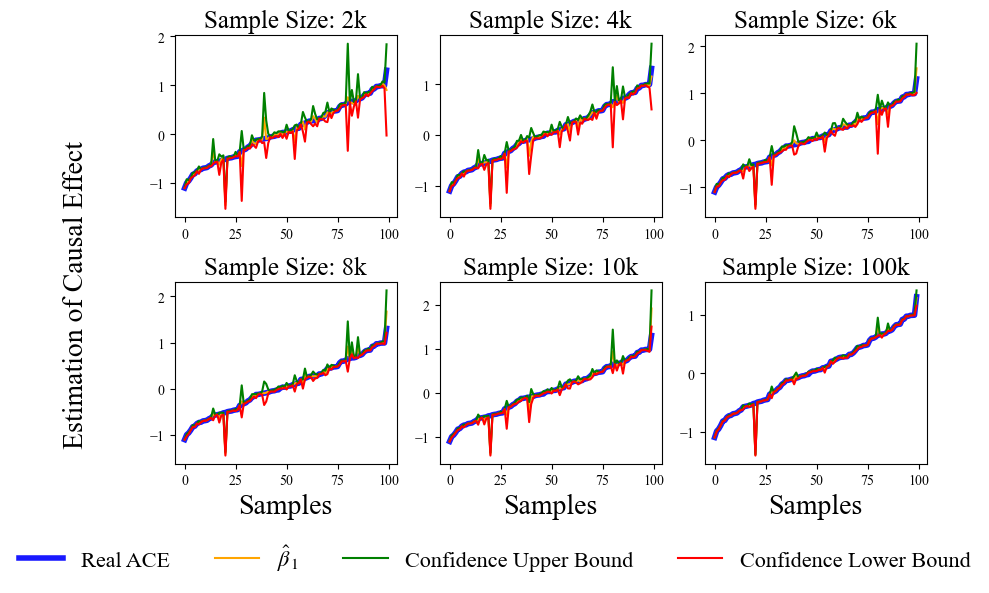

In [36]:
plot_dags(lst_result)

In [21]:
# dag_data_back = dag_data.copy()
# dag_data_back

In [49]:
# 保存 dag_data 到本地文件
with open(data_file_name, 'wb') as f:
    pickle.dump(dag_data, f)

In [4]:
# 保存一组运行结果到本地文件
with open('lst_result_2.pkl', 'wb') as f:
    pickle.dump(lst_result, f)

NameError: name 'lst_result' is not defined

In [24]:
# lst_result_copy = lst_result.copy()
# lst_result_copy

In [91]:
# 接下来对结果进行一些指标上的度量，并准备画图
def evaluate_result(lst_result):
    lst_evaluate = []
    for item in lst_result:
        sample_size = item[0]
        noise_level = item[1]
        lst_ace = item[2]
        lst_estimated_ace = item[3]
        lst_upper_bound_of_confidence_interval = item[4]
        lst_lower_bound_of_confidence_interval = item[5]
        lst_bound_size = []
        lst_bound_size_rate = []
        lst_relative_error = []
        N = len(lst_ace)
        cnt1, cnt2 = 0, 0
        for i in range(N):
            if lst_ace[i] > 0:
                if lst_lower_bound_of_confidence_interval[i] > 0:
                    cnt1 += 1
            elif lst_ace[i] < 0:
                if lst_upper_bound_of_confidence_interval[i] < 0:
                    cnt1 += 1
            lst_bound_size.append(abs(lst_upper_bound_of_confidence_interval[i]-lst_lower_bound_of_confidence_interval[i]))
            lst_bound_size_rate.append(lst_bound_size[-1]/abs(lst_ace[i]))
            lst_relative_error.append(abs(lst_estimated_ace[i]-lst_ace[i])/abs(lst_ace[i]))
        cnt2 = [1 for i in range(N) if lst_lower_bound_of_confidence_interval[i] < lst_ace[i] < lst_upper_bound_of_confidence_interval[i]]
        cnt2 = sum(cnt2)
        print("cnt1:", cnt1, "cnt2:", cnt2, "N:", N)
        accuracy = cnt1 / N
        prob = cnt2 / N
        mean_bound_size = sum(lst_bound_size) / N
        mean_bound_size_rate = sum(lst_bound_size_rate) / N
        mean_relative_error = sum(lst_relative_error) / N
        lst_evaluate.append([sample_size, accuracy, prob, mean_bound_size, mean_bound_size_rate, mean_relative_error])
        print(f"Sample Size: {sample_size}, Noise Level: {noise_level}")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Prob:  {prob:.4f}") # 置信区间包含真实值的概率，多打印几位小数
        print(f"Mean Bound Size: {mean_bound_size}")
        print(f"Mean Bound Size Rate: {mean_bound_size_rate}")
        print(f"Mean Relative Error: {mean_relative_error}")
        print("\n")
    return lst_evaluate
        

In [109]:
# 绘制度量结果，横轴为log(样本量)，纵轴为度量指标
def plot_evaluate(lst_evaluate):
    lst_sample_size = [item[0] for item in lst_evaluate]
    lst_accuracy = [item[1] for item in lst_evaluate]
    lst_prob = [item[2] for item in lst_evaluate]
    lst_mean_bound_size = [item[3] for item in lst_evaluate]
    lst_mean_bound_size_rate = [item[4] for item in lst_evaluate]
    lst_mean_relative_error = [item[5] for item in lst_evaluate]
    plt.figure()
    plt.plot(np.log(lst_sample_size), lst_accuracy, label="Mean Sign Consistency")
    plt.plot(np.log(lst_sample_size), lst_prob, label="Mean Coverage")
    # plt.plot(np.log(lst_sample_size), lst_mean_bound_size, label="Mean Bound Size")
    plt.plot(np.log(lst_sample_size), lst_mean_bound_size_rate, label=f'Mean Relative SE$(\\beta_1)$')
    plt.plot(np.log(lst_sample_size), lst_mean_relative_error, label="Mean Relative Error")
    plt.xlabel("log(Sample Size)", fontsize=14)
    plt.ylabel("Metrics", fontsize=14)
    plt.legend(fontsize=12)
    plt.savefig("Metrics.png", dpi=300)
    plt.show()
    

In [98]:
lst_evaluate = evaluate_result(lst_result)

cnt1: 87 cnt2: 92 N: 100
Sample Size: 2000, Noise Level: 0.5
Accuracy: 0.8700
Prob:  0.9200
Mean Bound Size: 0.17245596884495068
Mean Bound Size Rate: 0.868698443557098
Mean Relative Error: 0.21227299073926514


cnt1: 92 cnt2: 96 N: 100
Sample Size: 4000, Noise Level: 0.5
Accuracy: 0.9200
Prob:  0.9600
Mean Bound Size: 0.12228180257993043
Mean Bound Size Rate: 0.6138388427021556
Mean Relative Error: 0.17758727574719288


cnt1: 93 cnt2: 92 N: 100
Sample Size: 6000, Noise Level: 0.5
Accuracy: 0.9300
Prob:  0.9200
Mean Bound Size: 0.09976246669855804
Mean Bound Size Rate: 0.503782102439459
Mean Relative Error: 0.13637536426674296


cnt1: 93 cnt2: 93 N: 100
Sample Size: 8000, Noise Level: 0.5
Accuracy: 0.9300
Prob:  0.9300
Mean Bound Size: 0.08607345421626557
Mean Bound Size Rate: 0.4344806305129929
Mean Relative Error: 0.09428142645607553


cnt1: 96 cnt2: 93 N: 100
Sample Size: 10000, Noise Level: 0.5
Accuracy: 0.9600
Prob:  0.9300
Mean Bound Size: 0.07727868528731593
Mean Bound Size Rate

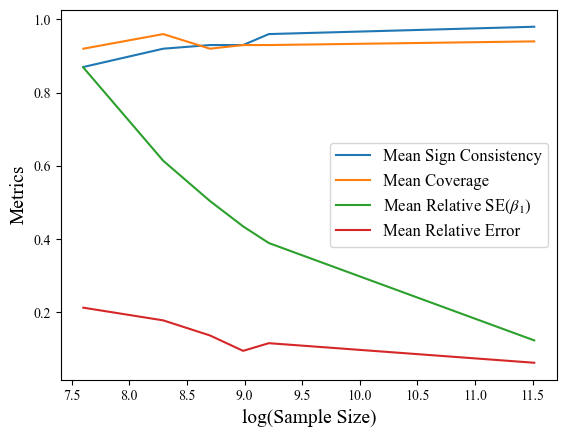

In [110]:
plot_evaluate(lst_evaluate)

In [2]:
# 读取本地文件中的 dag_data
with open('lst_result_2.pkl', 'rb') as f:
    lst_result = pickle.load(f)
    plot_dags(lst_result)

EOFError: Ran out of input

In [28]:
# 读取本地文件中的 dag_data
with open('dag_data.pkl', 'rb') as f:
    dag_data = pickle.load(f)
    # plot_dags(dag_data)

dag_data

[{'dag_id': 1,
  'sample_size': 2000,
  'noise_level': 0.1,
  'weight_matrix': array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.04405958,
           0.65786392,  0.        ,  0.        ,  0.96798046,  0.        ,
           0.        ,  0.73803902, -0.72072961,  0.        , -0.60082986],
         [ 0.        ,  0.        ,  0.        , -0.61530741, -0.13518346,
           0.22499859,  0.        ,  0.        ,  0.        , -0.33643964,
           0.        ,  0.        ,  0.04828606, -0.46118467, -0.05878399],
         [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          -0.10812809,  0.51388884, -0.840569  ,  0.        ,  0.        ,
           0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
           0.        ,  0.        , -0.35416948,  0.46820335,  0.        ,
           0.        ,  0.1968969 ,  0.        ,  0.        ,  0.29720848],
         [ 0.      

In [29]:
sample_sizes = [2000, 4000, 6000, 8000, 10000, 100000]
noise_levels = [i for i in [0.1, 0.5, 1.0]]  # 噪声强度

In [30]:
lst_result = calculate_result(dag_data, sample_sizes, noise_levels)
lst_result

[[2000,
  0.1,
  [0.04475458128786529,
   0.09631829929847237,
   -0.9258083348642581,
   -0.5218713528276653,
   -0.15818565290793477,
   -0.7701916215596079,
   -0.6647638716917931,
   -0.4759696312708297,
   1.0147753682019227,
   -0.44975486094996686,
   -0.24354488310911118,
   -0.3075875402275129,
   0.9706099677819515,
   0.33022663798186735,
   0.8846517067591773,
   0.4141135190257317,
   -0.10342915632484702,
   -0.15287729676443984,
   0.16455741742435817,
   0.6182238074582673,
   0.05829392971835029,
   -0.6619850795471418,
   -0.012760468842002234,
   0.5215305003228645,
   0.0427636621244839,
   0.3561603342341159,
   -0.09467990864828603,
   -0.5501970807402181,
   -0.1427356280165355,
   -0.08786167317659233,
   0.5021212139282671,
   0.44894974580070346,
   -0.5647149530915501,
   0.7385779820141593,
   -0.12427790395101414,
   -0.3033409214361382,
   -0.5919623111514773,
   -0.8489591947023976,
   -0.5964440146738571,
   -0.008443742168404055,
   -0.8826986672586499,